# Improve Chat LangChain

Deep dive on composition of LangChain docs to inform indexing using with ChatLangChain.

## Index Design

### Documetation Loading & Analysis

Follow what [is done](https://github.com/langchain-ai/chat-langchain/blob/master/backend/ingest.py) in `ChatLangChain`.

In [25]:
import re
import asyncio
import nest_asyncio
from typing import Generator
from bs4 import BeautifulSoup, SoupStrainer
from bs4 import BeautifulSoup, Doctype, NavigableString, Tag
from langchain.document_loaders import RecursiveUrlLoader, SitemapLoader

def metadata_extractor(meta: dict, soup: BeautifulSoup) -> dict:
    title = soup.find("title")
    description = soup.find("meta", attrs={"name": "description"})
    html = soup.find("html")
    return {
        "source": meta["loc"],
        "title": title.get_text() if title else "",
        "description": description.get("content", "") if description else "",
        "language": html.get("lang", "") if html else "",
        **meta,
    }


def langchain_docs_extractor(soup: BeautifulSoup) -> str:
    # Remove all the tags that are not meaningful for the extraction.
    SCAPE_TAGS = ["nav", "footer", "aside", "script", "style"]
    [tag.decompose() for tag in soup.find_all(SCAPE_TAGS)]

    def get_text(tag: Tag) -> Generator[str, None, None]:
        for child in tag.children:
            if isinstance(child, Doctype):
                continue

            if isinstance(child, NavigableString):
                yield child
            elif isinstance(child, Tag):
                if child.name in ["h1", "h2", "h3", "h4", "h5", "h6"]:
                    yield f"{'#' * int(child.name[1:])} {child.get_text()}\n\n"
                elif child.name == "a":
                    yield f"[{child.get_text(strip=False)}]({child.get('href')})"
                elif child.name == "img":
                    yield f"![{child.get('alt', '')}]({child.get('src')})"
                elif child.name in ["strong", "b"]:
                    yield f"**{child.get_text(strip=False)}**"
                elif child.name in ["em", "i"]:
                    yield f"_{child.get_text(strip=False)}_"
                elif child.name == "br":
                    yield "\n"
                elif child.name == "code":
                    parent = child.find_parent()
                    if parent is not None and parent.name == "pre":
                        classes = parent.attrs.get("class", "")

                        language = next(
                            filter(lambda x: re.match(r"language-\w+", x), classes),
                            None,
                        )
                        if language is None:
                            language = ""
                        else:
                            language = language.split("-")[1]

                        lines: list[str] = []
                        for span in child.find_all("span", class_="token-line"):
                            line_content = "".join(
                                token.get_text() for token in span.find_all("span")
                            )
                            lines.append(line_content)

                        code_content = "\n".join(lines)
                        yield f"```{language}\n{code_content}\n```\n\n"
                    else:
                        yield f"`{child.get_text(strip=False)}`"

                elif child.name == "p":
                    yield from get_text(child)
                    yield "\n\n"
                elif child.name == "ul":
                    for li in child.find_all("li", recursive=False):
                        yield "- "
                        yield from get_text(li)
                        yield "\n\n"
                elif child.name == "ol":
                    for i, li in enumerate(child.find_all("li", recursive=False)):
                        yield f"{i + 1}. "
                        yield from get_text(li)
                        yield "\n\n"
                elif child.name == "div" and "tabs-container" in child.attrs.get(
                    "class", [""]
                ):
                    tabs = child.find_all("li", {"role": "tab"})
                    tab_panels = child.find_all("div", {"role": "tabpanel"})
                    for tab, tab_panel in zip(tabs, tab_panels):
                        tab_name = tab.get_text(strip=True)
                        yield f"{tab_name}\n"
                        yield from get_text(tab_panel)
                elif child.name == "table":
                    thead = child.find("thead")
                    header_exists = isinstance(thead, Tag)
                    if header_exists:
                        headers = thead.find_all("th")
                        if headers:
                            yield "| "
                            yield " | ".join(header.get_text() for header in headers)
                            yield " |\n"
                            yield "| "
                            yield " | ".join("----" for _ in headers)
                            yield " |\n"

                    tbody = child.find("tbody")
                    tbody_exists = isinstance(tbody, Tag)
                    if tbody_exists:
                        for row in tbody.find_all("tr"):
                            yield "| "
                            yield " | ".join(
                                cell.get_text(strip=True) for cell in row.find_all("td")
                            )
                            yield " |\n"

                    yield "\n\n"
                elif child.name in ["button"]:
                    continue
                else:
                    yield from get_text(child)

    joined = "".join(get_text(soup))
    return re.sub(r"\n\n+", "\n\n", joined).strip()

nest_asyncio.apply()

def load_docs():
    loader = SitemapLoader(
        "https://python.langchain.com/sitemap.xml",
        filter_urls=["https://python.langchain.com/"],
        parsing_function=langchain_docs_extractor,
        default_parser="lxml",
        bs_kwargs={
            "parse_only": SoupStrainer(
                name=("article", "title", "html", "lang", "content")            ),
        },
        meta_function=metadata_extractor,
    )
    docs = loader.load()
    return docs

docs = load_docs()
docs_texts = [d.page_content for d in docs]
len(docs)

1316

### Overview of docs
 
* Visualize tokens per doc
* Clean outliers

In [ ]:
import pandas as pd
import tiktoken

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

docs_data = []
for doc in docs:
    doc_text = doc.page_content  # Getting text from each document
    tokens = num_tokens_from_string(doc_text, "cl100k_base")  # Calculate tokens
    char_count = len(doc_text)  # Calculate character count
    source = doc.metadata['source']  # Extract source from metadata
    docs_data.append({
        'doc_text': doc_text,
        'tokens': tokens,
        'char_count': char_count,  # Add character count here
        'source': source
    })

docs_df = pd.DataFrame(docs_data)
# A few outliers w/ output spamming and non-rendering images
# https://github.com/langchain-ai/langchain/pull/19475
exclude = [691,729,891,215,955]
docs_df_clean=docs_df[~docs_df.index.isin(exclude)].copy()

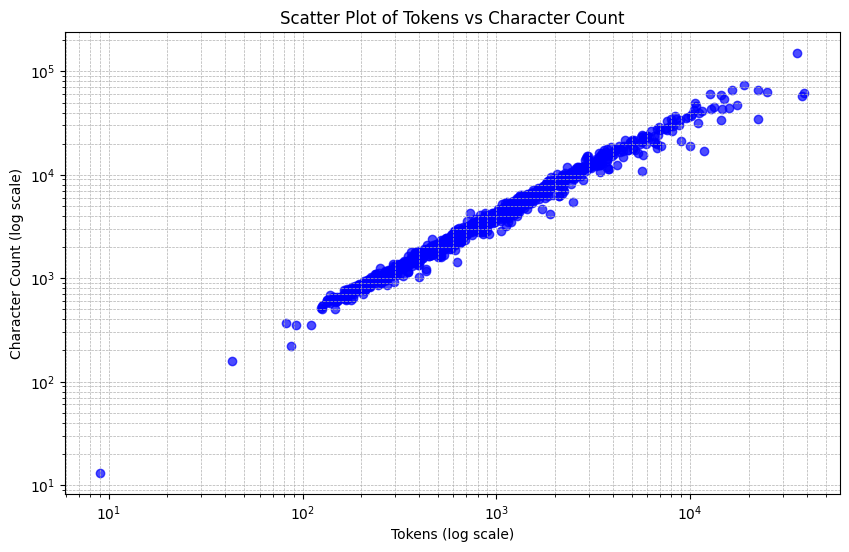

In [126]:
import matplotlib.pyplot as plt
# Tokens vs chars
plt.figure(figsize=(10, 6))
plt.scatter(docs_df_clean['tokens'], docs_df_clean['char_count'], color="blue", alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.title("Scatter Plot of Tokens vs Character Count")
plt.xlabel("Tokens (log scale)")
plt.ylabel("Character Count (log scale)")
plt.grid(True, which="both", ls="--", linewidth=0.5)

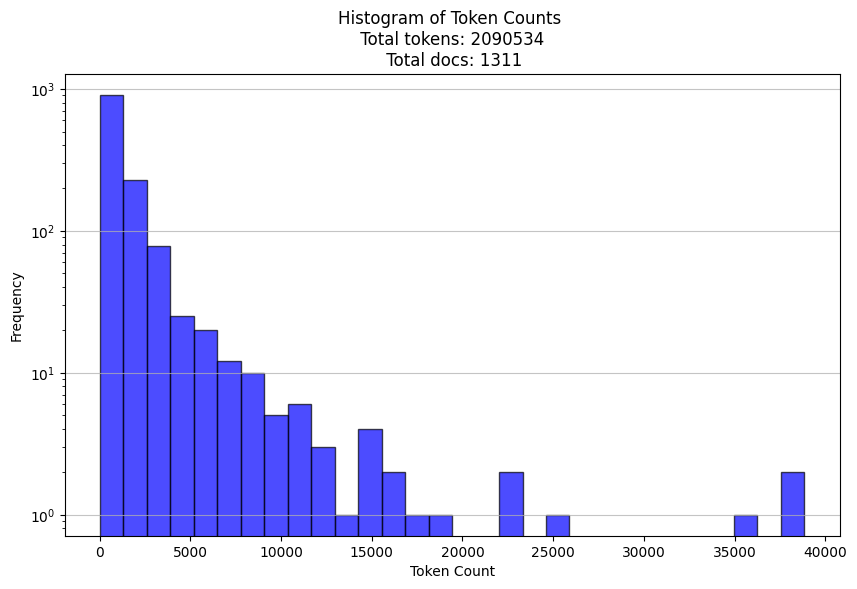

In [136]:
# Group by document type
docs_df_clean['doc_type'] = docs_df_clean['source'].apply(
    lambda x: x.split('https://python.langchain.com/docs/')[1].split('/')[0] if 'https://python.langchain.com/docs/' in x else 'Unknown'
)

# Calculate the number of tokens for each document
plt.figure(figsize=(10, 6))
plt.hist(docs_df_clean['tokens'], bins=30, color="blue", edgecolor="black", alpha=0.7)
total_tok = docs_df_clean.tokens.sum()
total_docs = docs_df_clean.shape[0]
plt.title(f"Histogram of Token Counts \n Total tokens: {total} \n Total docs: {total_docs}")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.yscale('log')

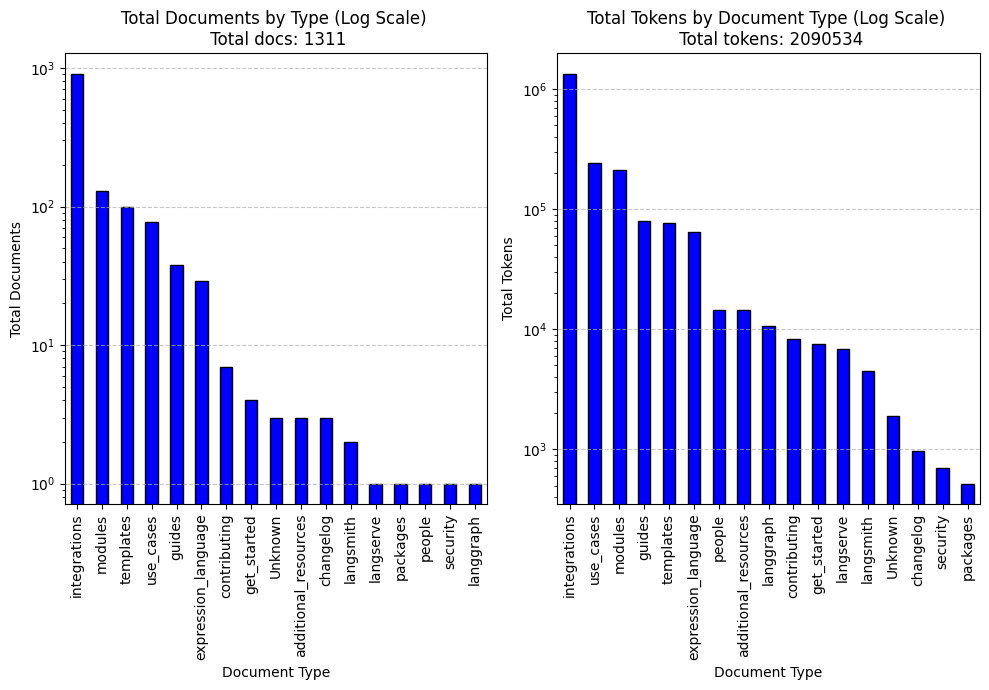

In [147]:
def plt_doc_num_and_tok(df):

    plt.figure(figsize=(10, 7))  # Adjust the overall figure size

    total_tok = df.tokens.sum()
    total_docs = df.shape[0]

    # First subplot for Total Documents by Type
    plt.subplot(1, 2, 1)  # (rows, columns, panel number)
    unique_doc_type_counts = df['doc_type'].value_counts()
    unique_doc_type_counts.plot(kind='bar', color='blue', edgecolor='black')
    plt.title(f'Total Documents by Type (Log Scale) \n Total docs: {total_docs}')
    plt.xlabel('Document Type')
    plt.ylabel('Total Documents')
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.yscale('log')
    
    # Second subplot for Total Tokens by Document Type
    plt.subplot(1, 2, 2)  # (rows, columns, panel number)
    tokens_by_doc_type = df.groupby('doc_type')['tokens'].sum().sort_values(ascending=False)
    tokens_by_doc_type.plot(kind='bar', color='blue', edgecolor='black')
    plt.title(f'Total Tokens by Document Type (Log Scale) \n Total tokens: {total_tok}')
    plt.xlabel('Document Type')
    plt.ylabel('Total Tokens')
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

plt_doc_num_and_tok(docs_df_clean)

In [138]:
unique_doc_type_counts

doc_type
integrations            911
modules                 130
templates                99
use_cases                77
guides                   38
expression_language      29
contributing              7
get_started               4
Unknown                   3
additional_resources      3
changelog                 3
langsmith                 2
langserve                 1
packages                  1
people                    1
security                  1
langgraph                 1
Name: count, dtype: int64

In [139]:
tokens_by_doc_type

doc_type
integrations            1346446
use_cases                240661
modules                  211035
guides                    80234
templates                 76485
expression_language       64568
people                    14548
additional_resources      14541
langgraph                 10723
contributing               8231
get_started                7550
langserve                  6880
langsmith                  4536
Unknown                    1903
changelog                   968
security                    706
packages                    519
Name: tokens, dtype: int64

Let's tier our docs for index design

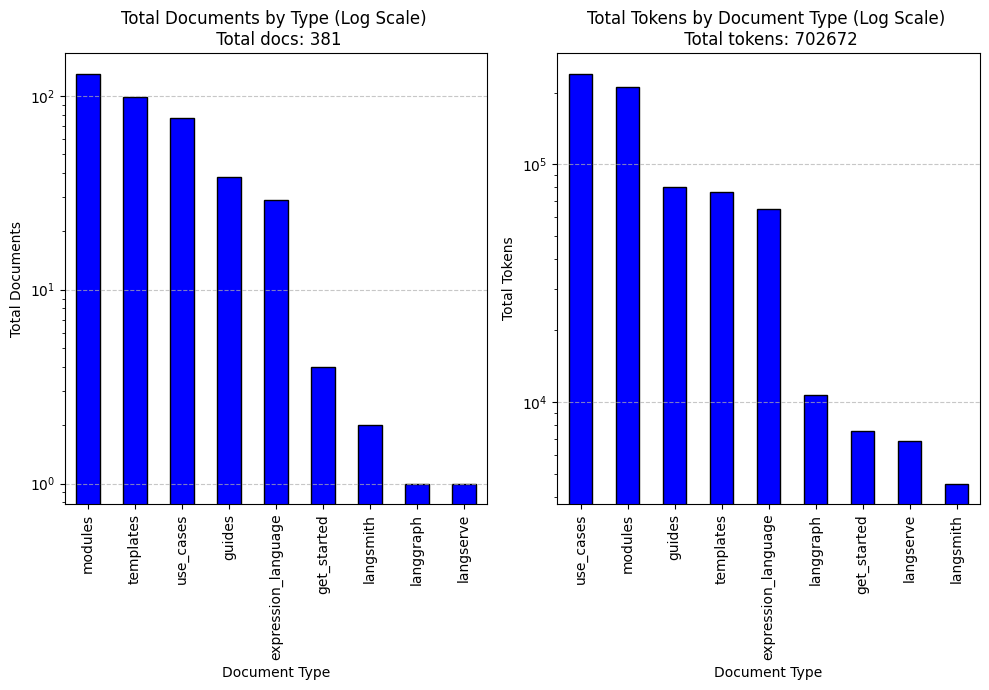

In [148]:
# Most critical doc types to prioritize with careful indexing
ignore = ['integrations','people','additional_resources','contributing','Unknown','changelog','security','packages']
docs_df_clean_tier_1=docs_df_clean[~docs_df_clean.doc_type.isin(ignore)]
plt_doc_num_and_tok(docs_df_clean_tier_1)

Hypothesis:

* Vast majority of user questions are addressed with RAG over tier 1 docs

Some ideas:

* Indexing with large chunk size (4k) over all tier 1 docs
* Parent-document indexing with large chunk size (4k) over all tier 1 docs, but return raw docs
* Parallel parent-document indexing over sub-sets of tier 1 docs (e.g., split out use-cases, expression langauge, then group all other)

### Eval set

Now, let's example a set of `ChatLangChain` questions.

We can download runs from LangSmith.

I did a pull of 30 days of ChatLangChain questions [using this](https://github.com/langchain-ai/lcel-teacher/blob/main/eval/build_eval_set.ipynb).

In [209]:
# Load data, drop dupes and NAs
raw_clc_questions = pd.read_csv('/Users/rlm/Desktop/Code/code-langchain/eval/fetched_data.csv').dropna()
raw_clc_questions = raw_clc_questions.drop_duplicates(subset=['question'], keep='first')
print(raw_clc_questions.shape)
raw_clc_questions.head(3)

(43605, 2)


,question,output
2,"I know that there is QA.chain in langchahin, w...","In addition to the `QA.chain` in Langchain, th..."
3,\nYou are an AI tool tasked with improving the...,"Lansdale, Pennsylvania CNN —\n\nRachael Gambin..."
4,Which tool will help me with detecting CSS fil...,The `GetElementsTool` can help you detect CSS ...


In [210]:
# Tok per question 
def safe_num_tokens_from_string(string: str, encoding_name: str):
    
    try:
        # Attempt to calculate the number of tokens
        return num_tokens_from_string(string, encoding_name)
    except ValueError as e:
        # Log the error or handle it as per your requirements
        print(f"Skipping question due to error: {e}")
        return None  # or return a default value like 0 or -1

raw_clc_questions['question_tokens'] = raw_clc_questions['question'].apply(lambda x: safe_num_tokens_from_string(x, "cl100k_base"))
raw_clc_questions.dropna(subset=['question_tokens'], inplace=True)

Skipping question due to error: Encountered text corresponding to disallowed special token '<|endoftext|>'.
If you want this text to be encoded as a special token, pass it to `allowed_special`, e.g. `allowed_special={'<|endoftext|>', ...}`.
If you want this text to be encoded as normal text, disable the check for this token by passing `disallowed_special=(enc.special_tokens_set - {'<|endoftext|>'})`.
To disable this check for all special tokens, pass `disallowed_special=()`.



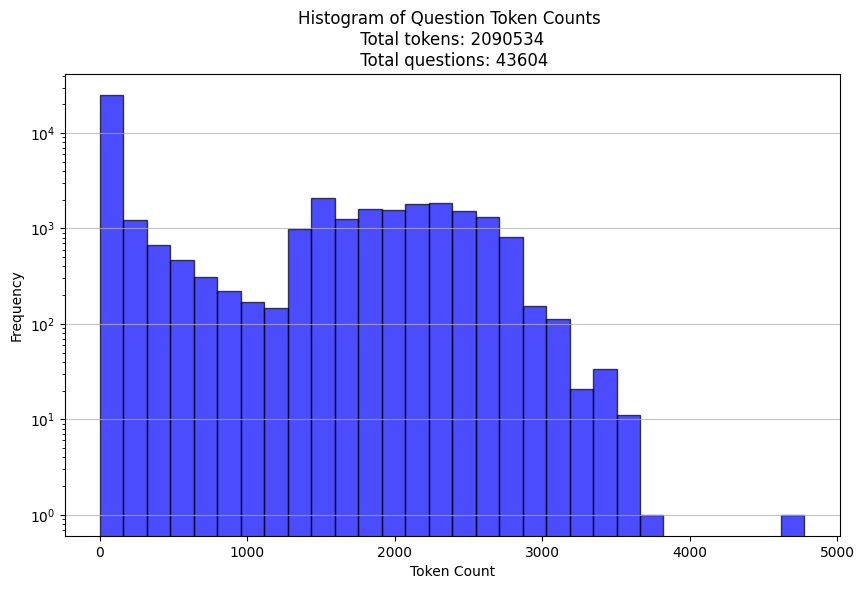

In [238]:
# Plot data 
def plt_hist(df):

    # Calculate the number of tokens for each document
    plt.figure(figsize=(10, 6))
    plt.hist(df['question_tokens'], bins=30, color="blue", edgecolor="black", alpha=0.7)
    total_tok = df['question_tokens'].sum()
    total_docs = df.shape[0]
    plt.title(f"Histogram of Question Token Counts \n Total tokens: {total} \n Total questions: {total_docs}")
    plt.xlabel("Token Count")
    plt.ylabel("Frequency")
    plt.grid(axis="y", alpha=0.75)
    plt.yscale('log')

plt_hist(raw_clc_questions)

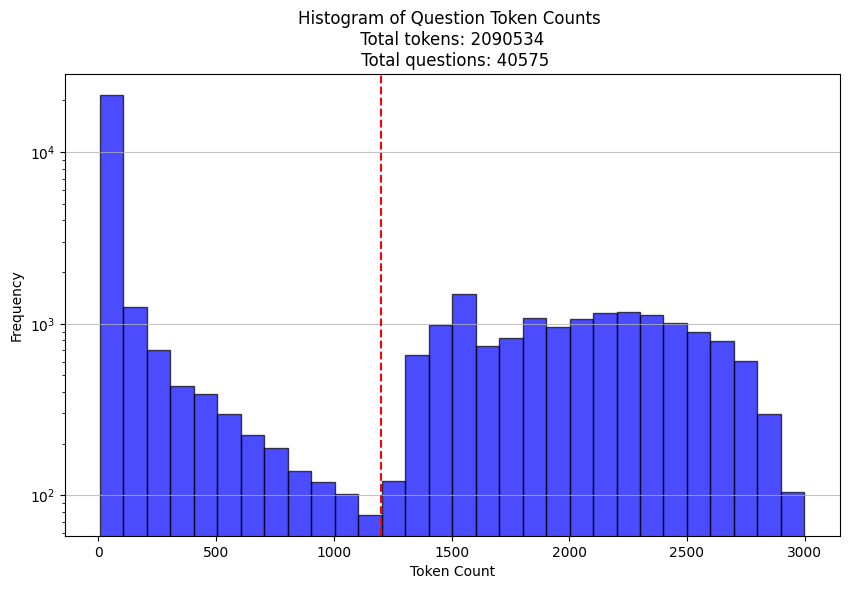

In [245]:
# Remove outliers
raw_clc_questions_filter=raw_clc_questions[(raw_clc_questions['question_tokens'] > 5) & (raw_clc_questions['question_tokens'] < 3000)]
plt_hist(raw_clc_questions_filter)
plt.axvline(1200,color='r',linestyle='--')

From inspection of a few examples: 
 
* Questions > `~1000 tok` tend to be code-dumping / spamming (e.g., here's a big code block)
* We want to isolate for crisp, short, well structured questions                           

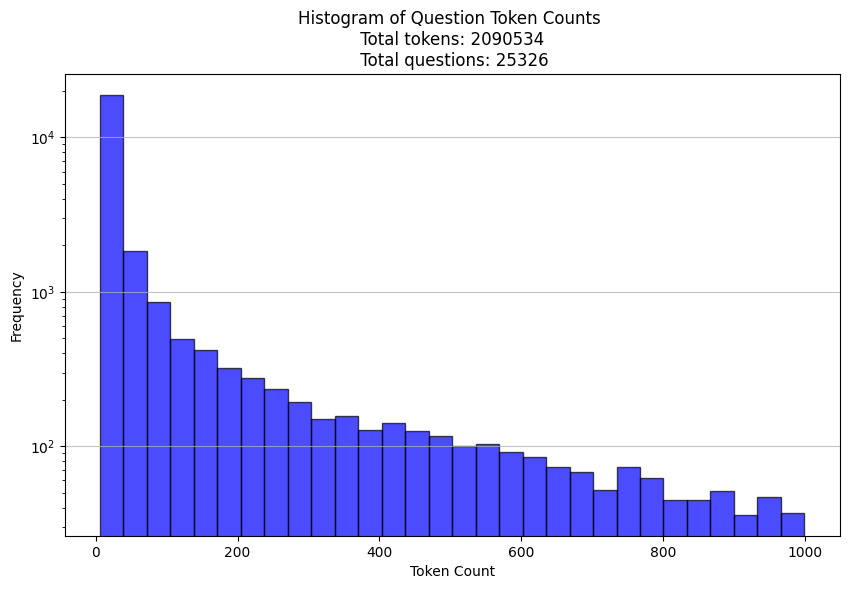

In [247]:
# Plot hist
raw_clc_questions_filter_sub_1k=raw_clc_questions_filter[raw_clc_questions_filter.question_tokens < 1000]
plt_hist(raw_clc_questions_filter_sub_1k)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, 'chat'),
  Text(1, 0, 'prompt'),
  Text(2, 0, 'agent'),
  Text(3, 0, 'tool'),
  Text(4, 0, 'function'),
  Text(5, 0, 'memory'),
  Text(6, 0, 'eval'),
  Text(7, 0, 'parse'),
  Text(8, 0, 'rag'),
  Text(9, 0, 'vectorstore'),
  Text(10, 0, 'loader'),
  Text(11, 0, 'sql'),
  Text(12, 0, 'local'),
  Text(13, 0, 'chatbot'),
  Text(14, 0, 'graph'),
  Text(15, 0, 'summarize'),
  Text(16, 0, 'extraction')])

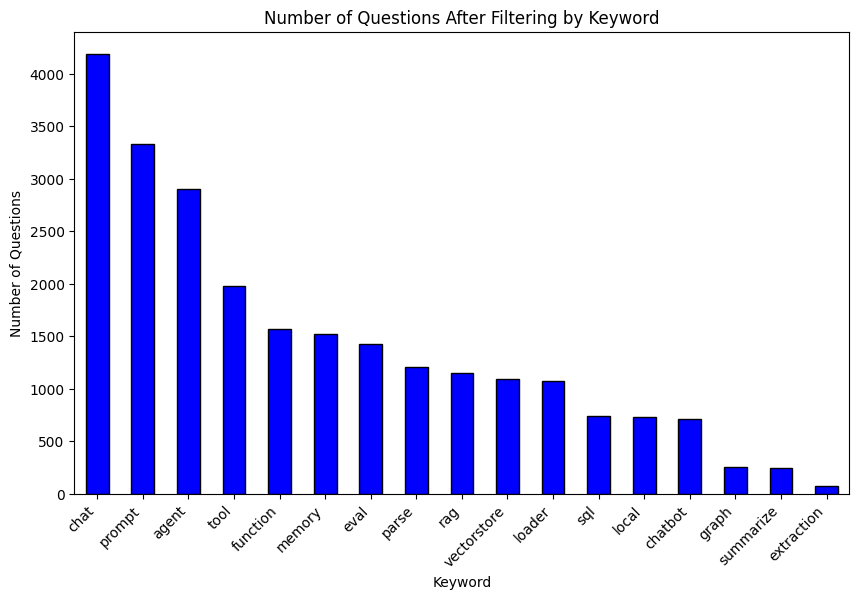

In [272]:
# Manual clustering
keywords=['extraction',
          'loader',
          'chatbot',
          'agent',
          'graph',
          'prompt',
          'rag',
          'summarize',
          'tool',
          'sql',
          'local',
          'parse',
          'memory',
          'chat',
          'vectorstore',
          'eval',
          'function']

# Store each
filtered_dfs = {}
df_sizes = {}

for key in keywords:
    filtered_df = raw_clc_questions_filter_sub_1k[raw_clc_questions_filter_sub_1k['question'].str.contains(key, case=False, na=False)]
    filtered_dfs[key] = filtered_df
    df_sizes[key] = len(filtered_df)

sizes_series = pd.Series(df_sizes)
sorted_sizes = sizes_series.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sorted_sizes.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Number of Questions After Filtering by Keyword')
plt.xlabel('Keyword')
plt.ylabel('Number of Questions')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability

In [271]:
filtered_dfs['chat'].sort_values('question_tokens')

,question,output,question_tokens,bin_index
52035,BedrockChat maxTokenCount,The `BedrockChat` model does not have a specif...,6.0,1
36478,openai chat model with memory,"The OpenAI Chat model supports memory, which a...",6.0,1
25839,create chat bot for pdf files,"To create a chatbot for PDF files, you can use...",6.0,1
25772,check rate limit chatopenai,The rate limit for the Chat API provided by Op...,6.0,1
33159,Chatbot with gemini pro,Gemini Pro is a chat model integration availab...,6.0,1
...,...,...,...,...
34960,"In this code, I am using a vector store retrie...",To adjust your code to account for typos in th...,993.0,7
51007,"entferne Redundanzen in ""import os\nimport sho...",Um Redundanzen in dem gegebenen Code zu entfer...,993.0,7
35799,from langchain.agents import Tool\nfrom langc...,The provided code sets up a Flask web applicat...,996.0,7
51514,\nclient = Client()\n\napp = FastAPI()\napp.ad...,O parâmetro `input_type=ChatRequest` na função...,999.0,7
